# Explorative Datenanalyse

Wir gehen jetzt die ersten Schritte der explorativen Datenanalyse, soweit wir das bisher gelernt haben, an einigen Beispielen durch.

In [1]:
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

## Wein

Den Anfang macht ein alter Datensatz, den man z.B. beim [UC Irvine Machine Learning Repository](https://archive-beta.ics.uci.edu/) herunterladen kann:

[Wine. (1991). UCI Machine Learning Repository.](https://archive-beta.ics.uci.edu/ml/datasets/wine)

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"

Der Datensatz hat, laut Dokumentation, 178 Zeilen (die hier und sonst auch oft *Instanzen* genannt werden) und 14 Variablen. Die erste Variable ist kategoriell und als `int` kodiert, aus `{1, 2, 3}`. Die anderen Variablen sind stetige reelle Variablen (also `float`). Die Nutzungslizenz ist CC-BY-4.0, also können wir den Datensatz frei verwenden, verändern und die Ergebnisse teilen, solange wir die Originalquelle nennen:
> Riccardo Leardi, riclea@anchem.unige.it

Der Datensatz besteht aus 2 Dateien:
* `wine.data`
* `wine.names`

Dabei ist `wine.data` der eigentliche Datensatz, ohne Metadaten, und `wine.names` enthält die Metadaten in menschenlesbarer Form.

Aus `wine.names` ziehen wir insbesondere diese Informationen:
> These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.
* The attributes are
  1) Alcohol
  2) Malic acid
  3) Ash
  4) Alcalinity of ash  
  5) Magnesium
  6) Total phenols
  7) Flavanoids
  8) Nonflavanoid phenols
  9) Proanthocyanins
  10) Color intensity
  11) Hue
  12) OD280/OD315 of diluted wines
  13) Proline       
* Number of Instances
  * class 1 59
  * class 2 71
  * class 3 48

Nachdem wir also erfolgreich die Daten heruntergeladen haben und die Metadaten dazu durchgelesen haben, können wir uns nun fragen, was wir damit anfangen wollen.

Eine offensichtliche Aufgabe ist, herauszufinden, ob sich die drei Klassen (d.h. die drei Hersteller von Wein) an der chemischen Zusammensetzung des Weins erkennen lassen. In Statistik formuliert: weicht die Verteilung der 13 Variablen hinreichend stark von Klasse zu Klasse ab, dass sich damit die einzelnen Datenpunkte (d.h. die Instanzen) den Klassen zuordnen lassen?

Wir können das als ein Spiel formulieren: wenn wir die erste Variable, die Klasse, löschen - lässt sie sich dann rekonstruieren?
In der einfachen Variante löschen wir die Klasse noch nicht, sondern nutzen sie um drei verschiedene Verteilungen für jedes der 13 Attribute zu schätzen. Danach können wir für jede Instanz unter Nichtbeachtung der Klasse einschätzen, zu welcher Verteilung sie am ehesten gehört und vergleichen, ob wir damit richtig liegen.

In der fortgeschrittenen Variante teilen wir die Daten in Trainings- und Testdaten auf oder bilden die drei (oder mehr) Klassen völlig ohne die Variable "Klasse" zu berücksichtigen. Wir werden aber zunächst einen Blick auf die Daten werfen.

Ganz unabhängig von den Klassen ist erstmal interessant: wie sind die Daten verteilt? Das fragen wir nun für jede Variable einzeln.

In [3]:
# Numpys genfromtxt geht von whitespace-separierten Daten aus,
#   daher geben wir den Delimiter explizit an:
data = np.genfromtxt(url, delimiter=",")
print(type(data), data.shape)
print(data[0]) # eine Instanz

<class 'numpy.ndarray'> (178, 14)
[1.000e+00 1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00
 3.060e+00 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]


In [4]:
klasse = data[:,0].astype("i8")
# Wenn klasse eine Python list wäre:
#klassenzahl = [klasse.count(d) for d in (1,2,3)]
# In Numpy geht es so:
unique, counts = np.unique(klasse, return_counts=True)
print(dict(zip(unique, counts)))
# Wenn counts eine Python list wäre:
#assert counts == [59, 71, 48]
# In Numpy geht es so:
print(np.equal(counts, [59, 71, 48]))
assert np.all(np.equal(counts, [59, 71, 48]))

{1: 59, 2: 71, 3: 48}
[ True  True  True]


min 11.03 max 14.83 range 3.8000000000000007 std 0.8095429145285168 n 178


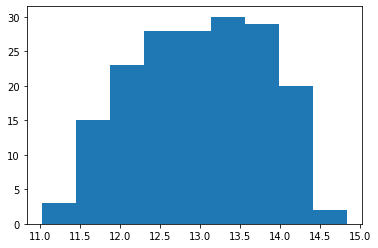

In [5]:
alcohol = data[:,1]
print("min", np.min(alcohol),
      "max", np.max(alcohol),
      "range", np.max(alcohol) - np.min(alcohol),
      "std", np.std(alcohol),
      "n", len(alcohol))
plt.hist(alcohol, bins="auto")
plt.show()

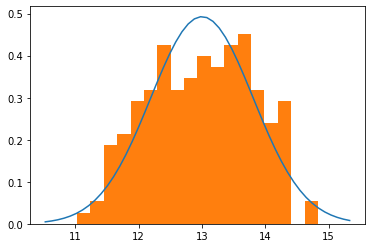

In [6]:
# Sieht annähernd normalverteilt aus, also:
mu, sigma = st.norm.fit(alcohol)
x = np.linspace(np.min(alcohol)-0.5, np.max(alcohol)+0.5, 50)
plt.plot(x, st.norm(mu, sigma).pdf(x))
plt.hist(alcohol, density=True, bins=18)
plt.show()

Wir müssen feststellen, dass diese Verteilung nicht besonders normal aussieht. Tatsächlich könnte man fast eine bimodale Verteilung erkennen - also eine Mischung aus 2 Normalverteilungen mit Erwartungswert nahe 12 und 13.5. Anstatt weiter am Bild Vermutungen anzustellen, wollen wir uns merken, dass wir eine Methode benötigen, um solche Vermutungen rigoros zu testen.

In unserem Beispiel können wir die Klasse als Hilfsvariable verwenden:

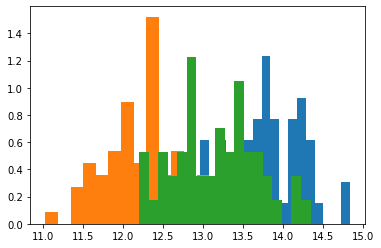

In [7]:
alcohol_by_class = [alcohol[data[:,0] == c] for c in (1,2,3)]
# Das ist nun eine Liste der Länge 3,
#   die jeweils Alkoholwerte innerhalb einer Klasse enthält.
for alcohol_class in alcohol_by_class:
    plt.hist(alcohol_class, density=True, bins=18)
    
plt.show()

Tatsächlich sind hier sofort klare Unterschiede zu erkennen. Der 'blaue' Wein (Klasse 1) hat im Schnitt mehr Alkohol als die anderen, der 'orangene' Wein (Klasse 2) hat im Schnitt weniger als die anderen. Wir wollen uns die jeweiligen Normalverteilungsdichten anzeigen lassen:

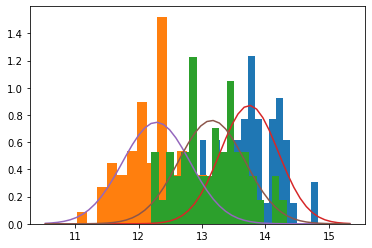

In [8]:
for alcohol_class in alcohol_by_class:
    plt.hist(alcohol_class, density=True, bins=18)

x = np.linspace(np.min(alcohol)-0.5, np.max(alcohol)+0.5, 50)
for alcohol_class in alcohol_by_class:
    mu, sigma = st.norm.fit(alcohol_class)
    plt.plot(x, st.norm(mu, sigma).pdf(x))
    
plt.show()

Wir sehen leider auch deutlich, dass die Überschneidungen so groß sind, dass wir im Bereich zwischen 12 und 14.5 Volumenprozent Alkoholgehalt keine sinnvollen Vorhersagen der Klasse machen können.

Der Vollständigkeit halber modellieren wir noch die gemischte Verteilung:

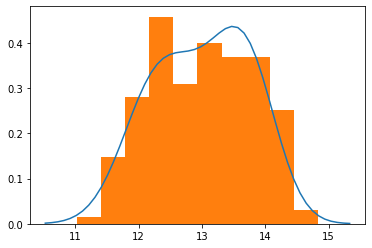

In [9]:
class_frequencies = counts / len(alcohol) # (59/178, 71/178, 48/178)
params = [st.norm.fit(alcohol_class) for alcohol_class in alcohol_by_class]
pdfs = [st.norm(*param).pdf for param in params]

def mixed_alcohol(x):
    return sum((class_frequency * pdf(x)
                for class_frequency, pdf
                in zip(class_frequencies, pdfs)))
    
plt.plot(x, mixed_alcohol(x))
plt.hist(alcohol, density=True)
plt.show()

Nachdem wir nun beim ersten Attribut, dem Alkoholgehalt, sehen konnten, dass es eine Abhängigkeit von der Klasse gibt, ist es naheliegend, alle anderen Attribute ebenfalls dahingehend zu untersuchen. Wir schreiben also den Code generisch um und betrachten dann alle Variablen auf einmal:

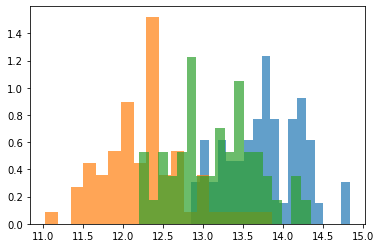

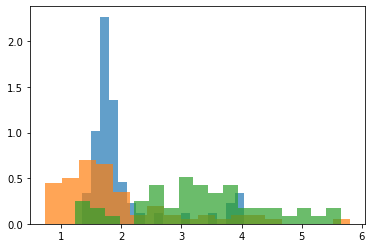

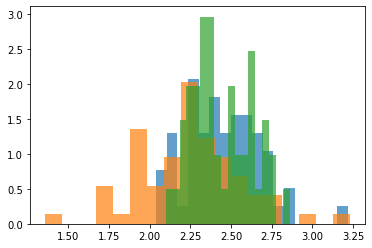

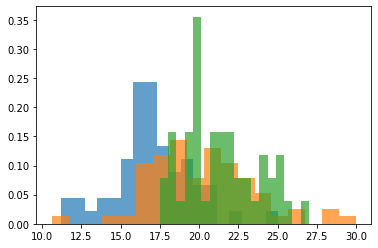

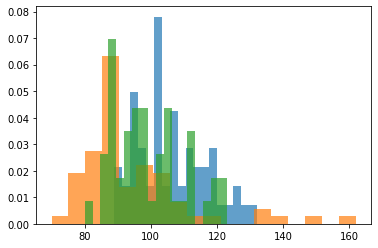

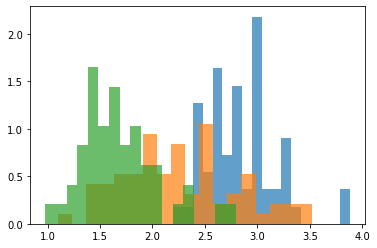

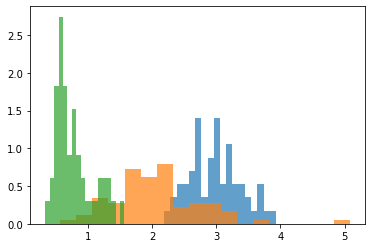

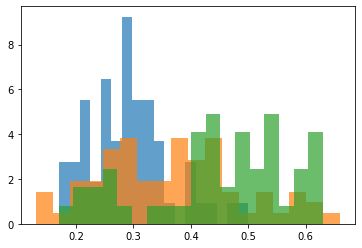

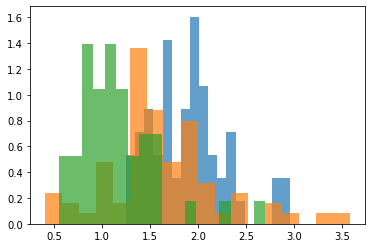

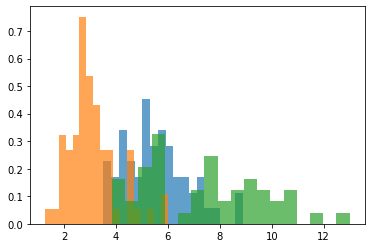

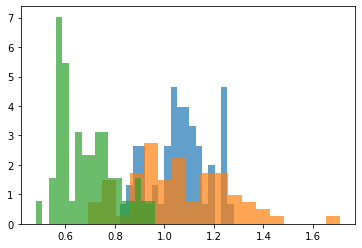

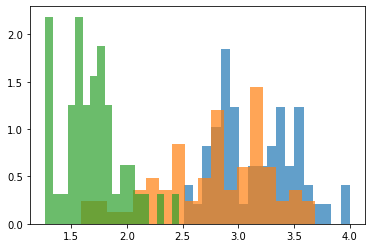

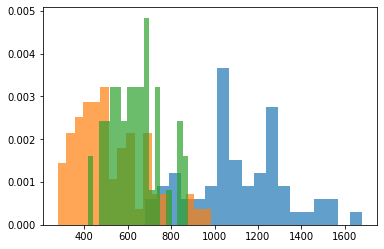

In [10]:
attributes_by_class = [[data[:,i][data[:,0] == c]
                        for c in (1,2,3)]
                       for i in range(1,14)]
# Das ist nun eine Liste der Länge 13,
#   die jeweils eine Liste der Länge 3 enthält

# 13 Plots mit je 3 Histogrammen:
for attribute in attributes_by_class:
    for attribute_class in attribute:
        plt.hist(attribute_class, density=True,
                 bins=18, alpha=0.7)
    plt.show()

An den Bildern sehen wir, dass neben Attribut 1 (Alkohol) auch Attribut 2 (Malic acid = Äpfelsäure), Attribut 12 (OD280/OD315 of diluted wines = Proteingehalt) und Attribut 13 (Proline = Aminosäure Prolin) geeignet sein könnten, um die Klassen auseinander zu halten.

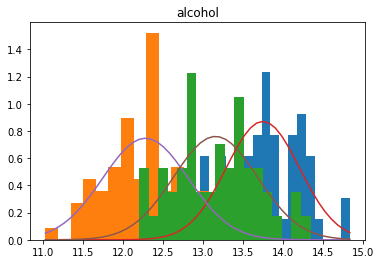

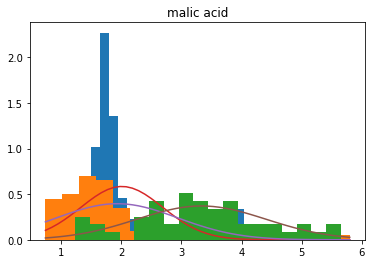

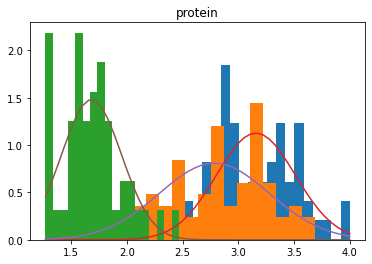

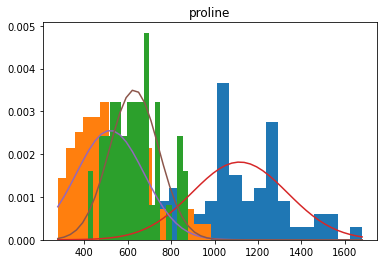

In [11]:
# benutze attributes_by_class
def plot_attribute_by_class(i, title=""):
    """use numbering from dataset, so alcohol = 1"""
    plt.title(title)
    attribute_by_class = attributes_by_class[i-1]
    attribute = data[:,i]
    xmin, xmax = np.min(attribute), np.max(attribute)
    for attribute in attribute_by_class:
        plt.hist(attribute, density=True, bins=18)
    x = np.linspace(xmin, xmax, 50)
    for attribute in attribute_by_class:
        mu, sigma = st.norm.fit(attribute)
        plt.plot(x, st.norm(mu, sigma).pdf(x))
    plt.show()
    
plot_attribute_by_class(1, "alcohol")
plot_attribute_by_class(2, "malic acid")
plot_attribute_by_class(12, "protein")
plot_attribute_by_class(13, "proline")

Wir sehen daran: Während Äpfelsäure sich als eher schlechter Indikator für die Klasse herausstellt, scheinen Proteingehalt und Prolingehalt gemeinsam deutlich besser als z.B. der Alkoholgehalt zur Vorhersage geeignet. Genauer: Klasse 3 lässt sich von Klasse 1 und 2 durch den Proteingehalt trennen, Klasse 1 lässt sich von Klasse 2 und 3 durch den Prolingehalt trennen. Wirklich sauber trennen kann man die Klassen allerdings nicht, wie man ebenfalls schon im Plot erkennt.

Zuletzt schauen wir uns noch den Zusammenhang zwischen einzelnen Attributen mit einem Scatterplot an:

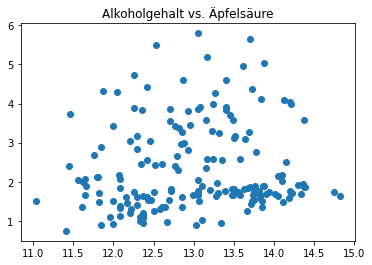

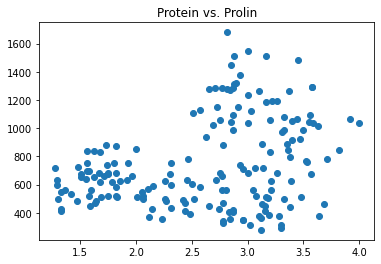

In [12]:
plt.title("Alkoholgehalt vs. Äpfelsäure")
plt.scatter(data[:,1], data[:,2])
plt.show()
plt.title("Protein vs. Prolin")
plt.scatter(data[:,12], data[:,13])
plt.show()

Während Alkoholgehalt und Äpfelsäure keinen direkt erkennbaren Zusammenhang haben, sehen wir im Protein-Prolin-Plot einen deutlichen weißen Fleck - ein hoher Prolingehalt geht auch mit hohem Proteingehalt einher. Nun wäre es interessant, Maße für diesen Zusammenhang auszurechnen und auf der anderen Seite in der Fachliteratur zu recherchieren, ob man rekonstruieren kann, wieso dieser Zusammenhang zustande kommt.

Um zu sehen, ob dieser Zusammenhang nur scheinbar da ist, und evtl. eigentlich durch Abhängigkeit von der Klasse entsteht, schauen wir uns noch den Scatterplot mit farblichen Unterscheidungen für die Klasse an:

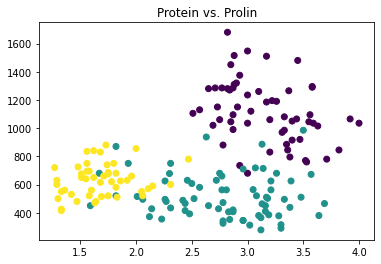

In [13]:
plt.title("Protein vs. Prolin")
plt.scatter(data[:,12], data[:,13], c=data[:,0])
plt.show()

Und tatsächlich ist ganz deutlich zu sehen, wie auch in den Histogrammen zuvor, dass sich durch die gemeinsame Betrachtung dieser beiden Attribute die Klassen relativ gut trennen lassen.

Wünschenswert wäre natürlich ein Koordinaten-unabhängiges Verfahren, die Klassen zu trennen (sodass wir also nicht von Hand 2 Variablen auswählen müssen). Das wird uns später mit der Hauptachsentranformation (principal component analysis, PCA) möglich sein.

## Starkregenereignisse (CatRaRE)

Der deutsche Wetterdienst (DWD) stellt Daten über Starkregenereignisse zur Verfügung
> Kataloge radar-basierter starker Niederschlagsereignisse als Grundlage für die Analyse des Starkregengeschehens und seines Schadenpotenzials in Deutschland seit 2001

* [Die Beschreibung der Datensätze findet sich beim DWD](https://www.dwd.de/DE/leistungen/catrare/catrare.html)
* [Die Metadaten (Beschreibung der Attribute) liegen als XLSX vor](https://opendata.dwd.de/climate_environment/CDC/event_catalogues/germany/precipitation/CatRaRE_v2021.01/CatRaRE_FelderBeschreibung_v2021_01.xlsx)
* [Die Datendownloadlinks müssen bei Verwendung angegeben werden](https://opendata.dwd.de/climate_environment/CDC/help/landing_pages/doi_landingpage_CatRaRE_V2021.01-de.html) \
  Lengfeld, Katharina; Walawender, Ewelina; Winterrath, Tanja; Weigl, Elmar; Becker, Andreas (2021): Starkregenereignisse Version 2021.01 mit Überschreitung der DWD-Warnstufe 3 für Unwetter basierend auf RADKLIM-RW Version 2017.002, \
  DOI: 10.5676/DWD/CatRaRE_W3_Eta_v2021.01
* [Die CSV-Datei, die wir betrachten wollen, lässt sich direkt herunterladen](https://opendata.dwd.de/climate_environment/CDC/event_catalogues/germany/precipitation/CatRaRE_v2021.01/data/CatRaRE_2001_2020_W3_Eta_v2021_01.csv)

In [14]:
url = "https://opendata.dwd.de/climate_environment/CDC/event_catalogues/germany/precipitation/CatRaRE_v2021.01/data/CatRaRE_2001_2020_W3_Eta_v2021_01.csv"
data = np.genfromtxt(url, delimiter=",", names=True,
                     dtype="i8,S10,S10,i8,i8,i8,S23,S23,i8,i8,f8,f8,f8,i8,i8,i8,i8,i8,i8,S23,S23,S23,f8,f8,f8,S12,S12,i8,i8,i8,i8,S6,i8,S6,i8,i8,f8,i8,i8,i8,f8,i8,i8,i8,i8,f8,f8,f8,i8,f8,i8,i8,i8,i8,i8,f8,i8,f8,f8,f8,f8")
data[0]

(1, b'W3_Eta_v20', b'W3_Eta_1', 1, 200101020350, 200101020750, b'2001-01-02T03:49:59.000', b'2001-01-02T07:50:00.000', 4, 51, 44.6, 51., 100., 1, 286, 183, -157462, -4575645, 8315037, b'Baden-W\xfcrttemberg', b'Breisgau-Hochschwarzwal', b'Feldberg (Schwarzwald)', 2.6, 51.5, 38., b'28', b'4', 5, 3, 0, 19, b'SWAZF', 19, b'SWAZF', 19, 12, 16.5, 20, 29, 19, 24.8, 30, 6, 620, 21, 0.1, 0.5, 64.9, 0, 0.4, 85, 312, 312, 1187, 585, 1102.3, 1462, -26.1, -311.9, -8.6, 223.5)

In [15]:
print(np.max(data["RRmax"]), np.min(data["RRmean"]))
print(np.mean(data["Duration"]))

462.0 25.6
5.051172893136403


Nun müssen wir uns eine Forschungsfrage stellen.
Offensichtlich ist immer die Frage, welche Verteilung die Variablen haben. Wir können wiederum die bloße Häufigkeit betrachten, also die Verteilung der Zeitpunkte. Dabei könnten wir den Verlauf der Jahre betrachten oder aber über die Jahre gemittelt den Einfluss des Monats auf die Häufigkeit analysieren. Letzteres ist naheliegend, da Starkregen als Wetterphänomen von den Jahreszeiten abhängt, wir also einen klaren Zusammenhang erwarten können.

Momentan ist der Anfangszeitpunkt eines Starkregenereignisses als `int` kodiert. Wir werden uns das zunutze machen, indem wir aus dem `int` `200101020350` einen `string` machen und den Monat herauslösen:

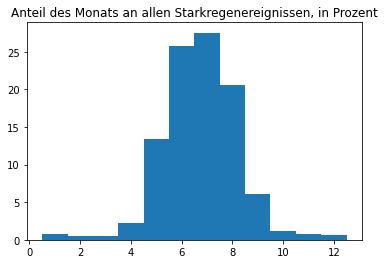

In [16]:
def getmonthfromintdate(intdate):
    return int(str(intdate)[4:6])

assert getmonthfromintdate(200101020350) == 1

def getmonthcount(data, month):
    mask = [getmonthfromintdate(intdate) == month
            for intdate in data["Start_Time"]]
    return len(data[mask])

months = np.arange(1,13)
counts = np.array([getmonthcount(data, month)
                   for month in months])
densities = 100 * counts / len(data)
plt.title("Anteil des Monats an allen Starkregenereignissen, in Prozent")
plt.bar(months, densities, width=1)
plt.show()

Wir sehen also deutlich den erwarteten Zusammenhang: im Juli und Juni sind Starkregenereignisse deutlich häufiger als im Winter.

Als nächstes können wir uns den Ort anschauen, also z.B. die Variable `GMD_RRmax` und den Ort `"Düsseldorf"`:

In [17]:
# Funktioniert nicht:
duessel = data[data["GMD_RRmax"] == "Düsseldorf"]
len(duessel)

/tmp/ipykernel_717753/440635942.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  duessel = data[data["GMD_RRmax"] == "Düsseldorf"]


0

In [18]:
# Stattdessen:
for entry in data["GMD_RRmax"]:
    if("sseldorf" in str(entry)):
        print(entry)
        break
        

b'D\xfcsseldorf'


7


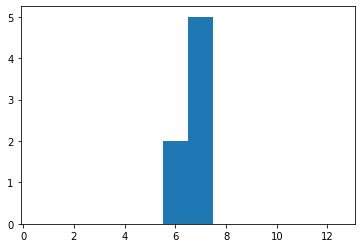

In [19]:
# Also:
city = b'D\xfcsseldorf'
citydata = data[data["GMD_RRmax"] == city]
print(len(citydata))
citycounts = np.array([getmonthcount(citydata, month)
                       for month in months])
plt.bar(months, citycounts, width=1)
plt.show()

Wir sehen: in Düsseldorf sind Juni und Juli bisher die einzigen Monate mit Starkregenereignissen gewesen.

Um weitere Korrelationen zu betrachten, sind diese 7 Ereignisse zu wenig. Es bringt uns also nicht viel, uns weiter auf Düsseldorf zu konzentrieren.

Um einen Eindruck von der räumlichen Verteilung zu bekommen, betrachten wir einen Scatterplot der Orte maximalen Niederschlags im RADKLIM-Gitter (`x_RRmax, y_RRmax`):

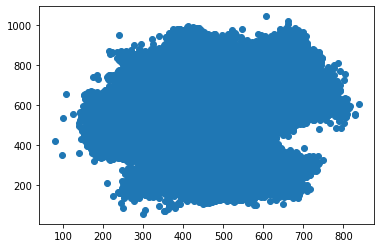

In [20]:
plt.scatter(data["x_RRmax"], data["y_RRmax"])
plt.show()

Man kann fast Deutschland erkennen, vor Allem aber, dass die y-Achse skaliert werden sollte. Wir informieren uns also über die Skalierung des RADKLIM-Gitters und erfahren, dass jeder Gitterpunkt genau $1\times 1 km^2$ entspricht.
Also muss der Plot nur quadratisch sein.
Damit wir etwas mehr von der Verteilung sehen können, machen wir noch jeden Punkt teiltransparent. So werden große Anhäufungen sichtbar:

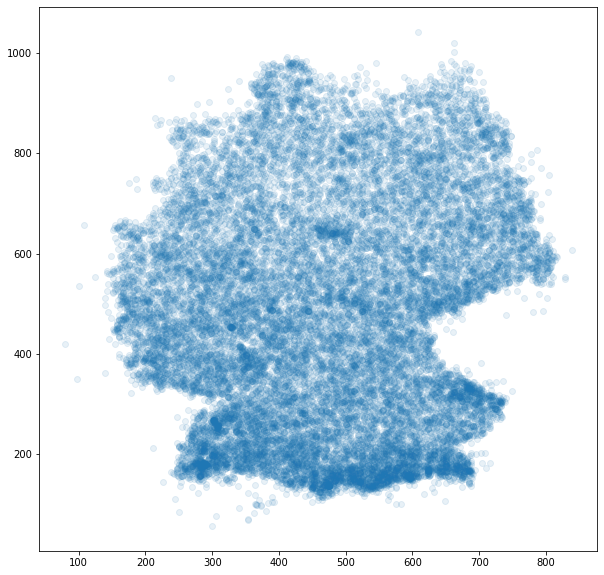

In [21]:
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(data["x_RRmax"], data["y_RRmax"], alpha=0.1)
plt.show()

Daran sehen wir, dass Starkregenereignisse im Süden häufiger vorkommen als im Norden. Wir könnten vermuten, dass es auch einen Zusammenhang mit der Dauer (`Duration`) der Ereignisse gibt:

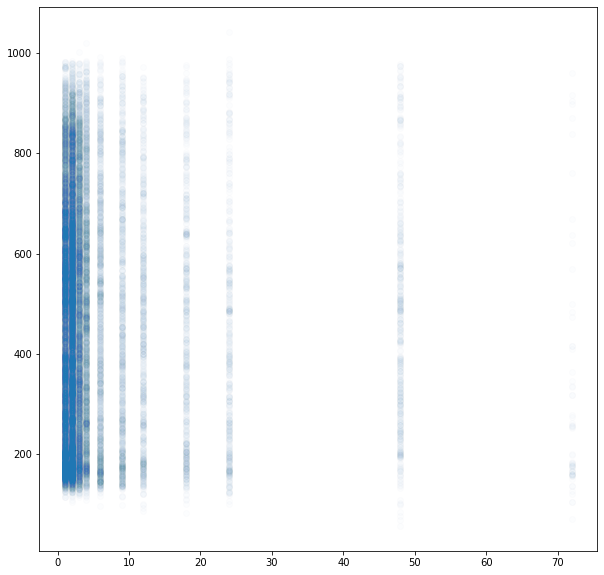

In [22]:
plt.scatter(data["Duration"], data["y_RRmax"], alpha=0.01)
plt.show()

Anstelle des vermuteten Zusammenhangs sehen wir etwas ganz anderes: dass die Dauer zumeist eine einstellige Zahl ist, längere Ereignisse kommen eher selten vor. Wir können noch durch farbliche Unterscheidung den räumlichen Zusammenhang untersuchen:

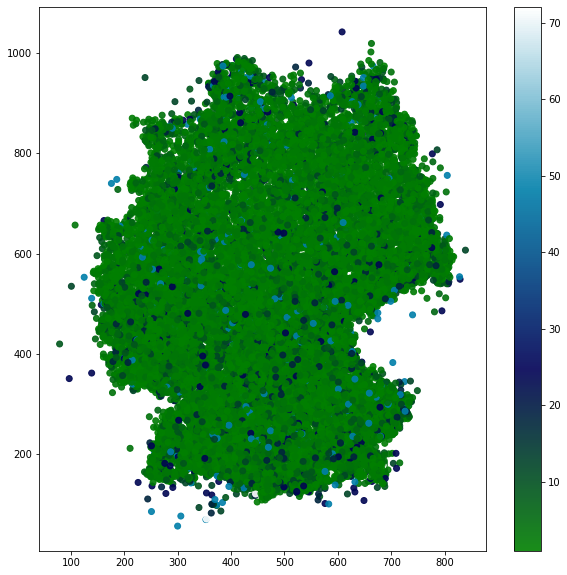

In [23]:
plt.scatter(data["x_RRmax"], data["y_RRmax"],
            alpha=0.9, c=data["Duration"],
            cmap="ocean")
plt.colorbar()
plt.show()

Da man hier nicht viel sehen kann (außer der Seltenheit längerer Ereignisse), schauen wir uns noch den analogen Plot für den mittleren Niederschlag an:

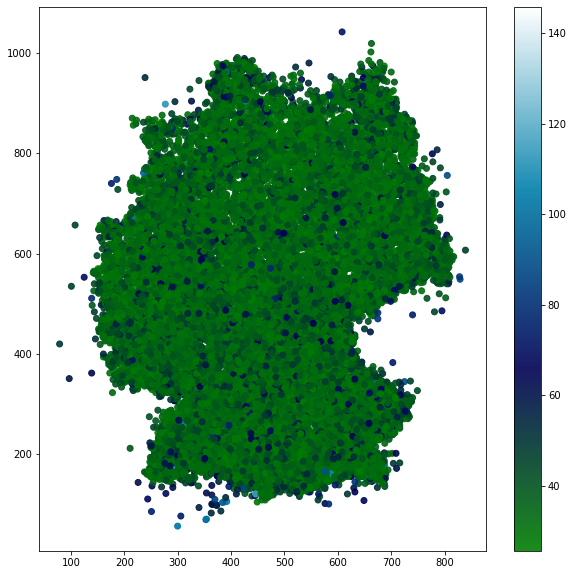

In [24]:
plt.scatter(data["x_RRmax"], data["y_RRmax"],
            alpha=0.9, c=data["RRmean"],
            cmap="ocean")
plt.colorbar()
plt.show()

Hier kommt der Verdacht auf, dass die Skala schwer zu lesen ist, weil die extremeren Ereignisse (in hellblau) so viel Raum beanspruchen. Wenn wir diese Ereignisse ausschließen, sehen wir mehr:

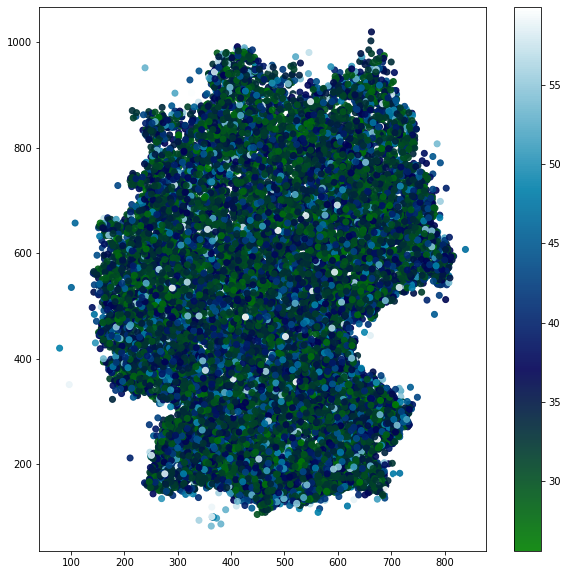

In [25]:
calm_data = data[data["RRmean"] < 60]
plt.scatter(calm_data["x_RRmax"], calm_data["y_RRmax"],
            alpha=0.9, c=calm_data["RRmean"],
            cmap="ocean")
plt.colorbar()
plt.show()

Den gleichen Effekt erzielen wir aber auch, wenn wir die Colormap anpassen:

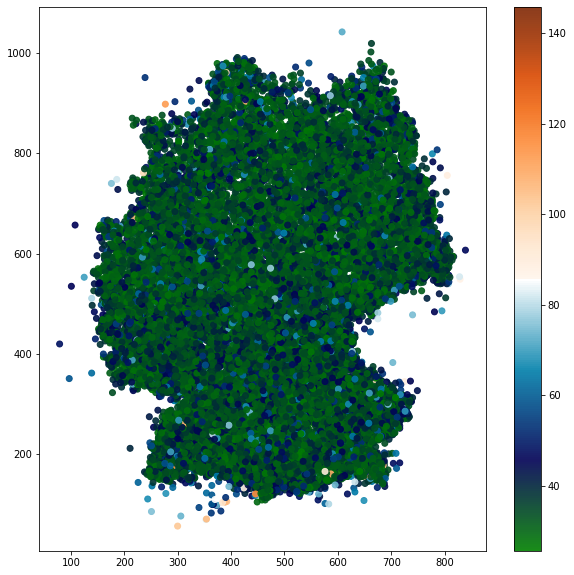

In [26]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
top = cm.get_cmap('ocean', 128)
bottom = cm.get_cmap('Oranges', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
my_colormap = ListedColormap(newcolors, name='My Colormap')

plt.scatter(data["x_RRmax"], data["y_RRmax"],
            alpha=0.9, c=data["RRmean"],
            cmap=my_colormap)
plt.colorbar()
plt.show()

Das soll uns für's erste an Starkregenereignissen genügen.

## Titanic

Jetzt wollen wir das Objekt-orientierte Interface von matplotlib kennen lernen, anhand des Titanic-Datensatzes.
Dieser ist bei Kaggle Teil einer ['Competition'](https://www.kaggle.com/competitions/titanic/data?select=train.csv).

Wir laden uns den Trainings-Datensatz herunter als `titanic.csv`.

In [27]:
# Das klappt so nicht:
try:
    data = np.genfromtxt("titanic.csv",
                         delimiter=",", names=True)
except ValueError as e:
    print("Problem: ',' im Feld 'Name'")

Problem: ',' im Feld 'Name'


In [28]:
# Wir überspringen die erste Zeile und tun so,
#   als würde der Name aus zwei Spalten bestehen.
data = np.genfromtxt("titanic.csv",
                     delimiter=",", skip_header=1,
                     usecols=(1,2,5,6,7,8,9),
                     dtype="i8,i8,S10,i8,i8,i8",
                     names=("Survived","Pclass","Sex",
                            "Age","SibSp","Parch"))
data[:4]

array([(0, 3, b'male', 22, 1, 0), (1, 1, b'female', 38, 1, 0),
       (1, 3, b'female', 26, 0, 0), (1, 1, b'female', 35, 1, 0)],
      dtype=[('Survived', '<i8'), ('Pclass', '<i8'), ('Sex', 'S10'), ('Age', '<i8'), ('SibSp', '<i8'), ('Parch', '<i8')])

In [29]:
print("Gesamt Überlebende:", np.sum(data["Survived"]))
print("Gesamt Passagiere:", len(data))
print("Überlebensquote:", np.sum(data["Survived"]) / len(data))

Gesamt Überlebende: 342
Gesamt Passagiere: 891
Überlebensquote: 0.3838383838383838


In [30]:
# Fehlende Daten:
data["Age"][:10]

array([22, 38, 26, 35, 35, -1, 54,  2, 27, 14])

In [31]:
aged_data = data[data["Age"] != -1]
print("Wrong mean:", np.mean(data["Age"]))
print("Correct mean:", np.mean(aged_data["Age"]))

Wrong mean: 22.85409652076319
Correct mean: 29.847605224963715


In [32]:
# Age correlated with survival?
nonsurvivors, survivors = tuple(aged_data[aged_data["Survived"] == i]
                                for i in range(0,2))
print(np.mean(survivors["Age"]), np.mean(nonsurvivors["Age"]))

29.01418439716312 30.425061425061426


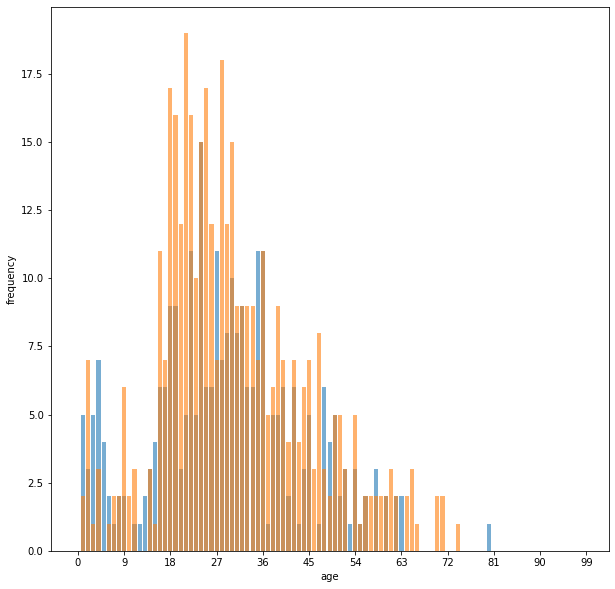

In [33]:
fig, ax = plt.subplots()

def ageplot(data, ax):
    ax.set_xlabel("age")
    ax.set_ylabel("frequency")
    ages = np.arange(0,99)
    count = np.array([len(data[data["Age"] == age])
                      for age in ages])
    ax.bar(ages, count, alpha=0.6)
    ax.set_xticks(np.linspace(0, 99, 12))

ageplot(survivors, ax)
ageplot(nonsurvivors, ax)
plt.show()

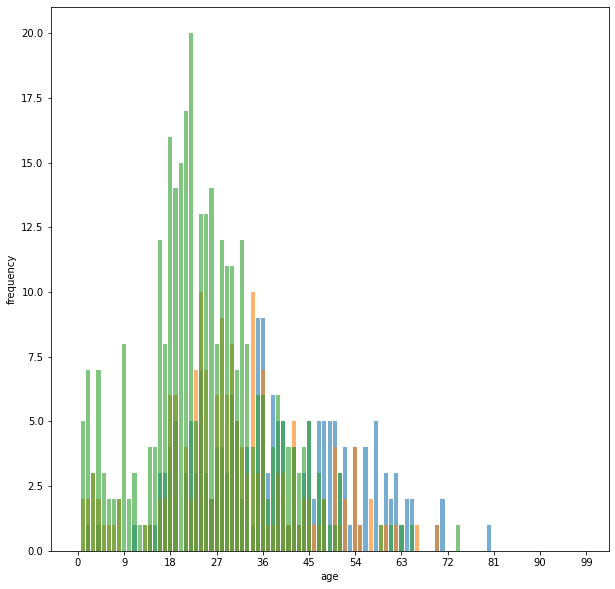

In [34]:
fig, ax = plt.subplots()
pclasses = (aged_data[aged_data["Pclass"] == i]
            for i in np.arange(1,4))
for pclass in pclasses:
    ageplot(pclass, ax)

plt.show()

Es ist wohl wenig verwunderlich, dass in Klasse 3 (der billigsten, der grünen) das Alter eher niedriger ist als in den anderen Klassen. Was man nebenbei auch bemerken kann, ist dass die Klasse 3 häufiger ist als die anderen Klassen (was vielleicht auch nicht für Verwunderung sorgen sollte).

Wenn wir sehen wollen, ob Passagierklasse und Überleben zusammenhängen, genügt ein Scatterplot:

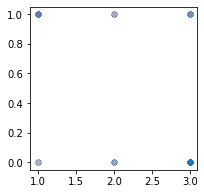

In [35]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(data["Pclass"], data["Survived"], alpha=0.005)
plt.show()

An diesem Scatterplot kann man sehen, dass es eine Korrelation gibt: Passagiere in Klasse 3 haben häufiger nicht überlebt. Passagiere, die überlebt haben, waren häufiger in Klasse 1. Allerdings war das nur sichtbar, weil wir `alpha = 0.005` gesetzt haben und krankt daran, dass die absolute Häufigkeit der Klassen nicht berücksichtigt wurde (ein Prävalenzfehler).

Korrekt wäre hier, die Wahrscheinlichkeit für einen Passagier in Klasse 3 auszurechnen, überlebt zu haben:

$$
P(Survived = 1 | Pclass = 3) = \dfrac{P(Survived = 1, Pclass = 3)}{P(Pclass = 3)}
$$

In [36]:
psp_mask = [(data["Survived"] == 1) & (data["Pclass"] == c)
        for c in np.arange(1,4)]
p_mask = [(data["Pclass"] == c)
          for c in np.arange(1,4)]
total_pclass_counts = [len(data[p_mask[c]])
       for c in np.arange(0,3)]
psp = [len(data[psp_mask[c]]) / total_pclass_counts[c]
       for c in np.arange(0,3)]
for c in range(3):
    print("P( Survived = 1 | Pclass =",c+1,") =", psp[c])

P( Survived = 1 | Pclass = 1 ) = 0.6296296296296297
P( Survived = 1 | Pclass = 2 ) = 0.47282608695652173
P( Survived = 1 | Pclass = 3 ) = 0.24236252545824846


Wir sehen, dass es für Passagiere der ersten Klasse wesentlich wahrscheinlicher ist, zu überleben, als zu sterben. Für Passagiere der zweiten Klasse ist es bereits schlechter als 50/50 und weniger als ein Viertel der Passagiere der dritten Klasse überlebte.

Es sollte uns nicht wundern, dass die Wahrscheinlichkeiten sich nicht zu $1$ aufsummieren, denn sie beziehen sich auf unterschiedliche Grundgesamtheiten. Betrachten wir stattdessen die umgekehrte bedingte Wahrscheinlichkeit, so erwarten wir eine Summe von $1$:


$$
P(Pclass = 3 | Survived = 1) = \dfrac{P(Survived = 1, Pclass = 3)}{P(Survived = 1)}
$$

In [37]:
total_survivor_count = len(data[data["Survived"] == 1])
pps = [len(data[psp_mask[c]]) / total_survivor_count
       for c in np.arange(0,3)]
for c in range(3):
    print("P( Pclass =",c+1,"| Survived = 1 ) =", pps[c])

assert sum(pps) == 1

P( Pclass = 1 | Survived = 1 ) = 0.39766081871345027
P( Pclass = 2 | Survived = 1 ) = 0.2543859649122807
P( Pclass = 3 | Survived = 1 ) = 0.347953216374269


Daran sehen wir, dass man am Überlebensstatus keineswegs ablesen kann, in welcher Klasse jemand reiste (denn es sind nicht gleich viele Passagiere pro Klasse unterwegs).

Es ist immer interessant, wie repräsentativ eine Stichprobe ist, um einschätzen zu können, wie gut sich gewonnene Zusammenhänge verallgemeinern lassen könnten. Daher betrachten wir nun, ob die Variable `Sex` mit anderen Variablen korreliert ist. Wir wissen zwar noch nicht, was wir tun, aber das nehmen wir mit als Motivation, später zu lernen, was wir getan haben:

In [38]:
try:
    st.pearsonr(data["Sex"], data["Age"])
except TypeError as e:
    print(str(e)[:100])

unsupported operand type(s) for +: 'float' and 'numpy.bytes_'


In [39]:
sexbool = (data["Sex"] == b"female")
r, pvalue = st.pearsonr(sexbool, data["Age"])
print(r, pvalue)

-0.003542250865523883 0.9159102368535484


Laut Dokumentation von Scipy Stats ist diese `pvalue` die Wahrscheinlichkeit, dass zwei unkorrelierte Variablen den Pearson-Korrelationskoeffizient $r$ haben. In unserem Fall ist also die Erklärung, dass die Daten unkorreliert sind, sehr plausibel. Zudem ist $r$ sehr klein, sodass eine vermutete Korrelation ebenfalls sehr klein dürfte.

In [40]:
print(st.pearsonr(sexbool, data["Survived"]))

PearsonRResult(statistic=0.5433513806577556, pvalue=1.4060661308783955e-69)


Hier sehen wir deutlich $r > 0.5$ und eine verschwindend kleine Wahrscheinlichkeit $p$, so ein $r$ bei eigentlich unkorrelierten Daten zu beobachten.

In [41]:
print(st.pearsonr(sexbool, data["Pclass"]))
print(st.pearsonr(sexbool, data["Age"]))
print(st.pearsonr(sexbool, data["SibSp"]))
print(st.pearsonr(sexbool, data["Parch"]))

PearsonRResult(statistic=-0.1319004906047393, pvalue=7.850524283802423e-05)
PearsonRResult(statistic=-0.003542250865523883, pvalue=0.9159102368535484)
PearsonRResult(statistic=0.1146308103894224, pvalue=0.0006076214735492635)
PearsonRResult(statistic=0.24548896009069912, pvalue=1.0739326016035032e-13)


Wir erwarten also naiv (der Dokumentation von Scipy Stats folgend), dass die Variable `SibSp` mit dem Geschlecht korreliert ist. Den Metadaten zufolge ist `SibSp` die Anzahl mitreisender Geschwister und Ehepartner. Auch beim Alter sehen wir eine Korrelation mit `SibSp`:

PearsonRResult(statistic=-0.16434928321340586, pvalue=8.120291402849121e-07)


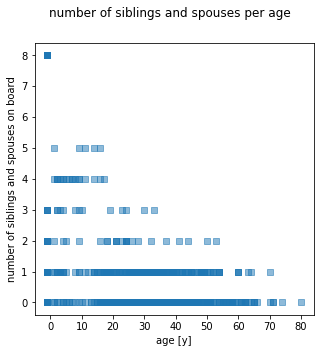

In [42]:
print(st.pearsonr(data["Age"], data["SibSp"]))
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle("number of siblings and spouses per age")
ax.scatter(data["Age"], data["SibSp"],
           alpha=0.5, marker="s")
ax.set_xlabel("age [y]")
ax.set_ylabel("number of siblings and spouses on board")

plt.show()